In [1]:
# 데이터프레임을 다루기 위한 라이브러리를 불러옵니다.
import numpy as np
import pandas as pd
import re


# 시각화를 위한 라이브러리를 불러옵니다.
import seaborn as sns
import math
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # 한글 폰트 경로
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# 정규성, 등분산성과 같은 데이터 분포를 살펴보기 위한 라이브러리를 불러옵니다.
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import anderson
from scipy.stats import bartlett
from scipy.stats import levene
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.formula.api import ols

# 의사결정트리모델
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import export_text
# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # 한글 폰트 경로
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)
# 원하는 csv파일을 불러옵니다.
df = pd.read_csv('데이터 찐최종본(완).csv')
# pd.set_option('display.max_rows', None)

# 새로운 열 이름을 생성하고 열 이름을 변경합니다.
new_columns = ['강좌명','수강생수','가격','평점','수강평수','난이도','강의시간','강의게시일']
df.columns = new_columns


# 각각의 속성을 원하는 시각화를 위해 형태를 바꿔줍니다. -> 시각화를 위한 데이터프레임을 생성합니다.
df['강좌명'] = df['강좌명'].str.replace('\n대시보드', '')
df['강의게시일'] = pd.to_datetime(df['강의게시일'].str.extract(r'(\d+)년 (\d+)월 (\d+)일').agg('-'.join, axis=1))
df['수강평수'] = df['수강평수'].str.extract(r'(\d+)개의').fillna(0).astype(int)
df['수강생수'] = df['수강생수'].str.replace('명', '')
df['수강생수'] = df['수강생수'].str.replace(',', '').astype(int)
df['가격'] = df['가격'].replace('무료', '₩0')
df['가격'] = df['가격'].str.extract(r'₩([^₩]+)$')
df['가격'] = df['가격'].str.replace(',', '').astype(int)
df['시간'] = df['강의시간'].str.extract(r'(\d+)시간', expand=False).fillna(0)
df['분'] = df['강의시간'].str.extract(r'(\d+)분', expand=False).fillna(0)
df['강의시간_분'] = df['시간'].astype(int)*60 + df['분'].astype(int)
df = df.drop(['시간', '분', '강의시간'], axis=1)
df['평점'] = df['평점'].str.extract(r'([\d.]+)').fillna(0).astype(float)
df['무료/유료'] = df['가격'].apply(lambda x: '무료' if x == 0 else '유료')
df['평가지수'] = df['수강평수'] * df['평점']
df = df[df['강의시간_분'] != 0]
df['강의시간당가격'] = df.apply(lambda row: int(row['가격'] / (row['강의시간_분'] / 60)), axis=1)
df = df[df['평가지수'] != 0]
# 중복되는 행을 제거해줍니다.
df = df.drop_duplicates('강좌명', keep='first')
#df.to_csv('데이터 시각화용.csv', index=False)


df_regression = df.copy()
df_regression = pd.concat([df_regression, pd.get_dummies(df_regression['난이도'], prefix='난이도')], axis=1)
df_regression['유무료'] = df['무료/유료'].apply(lambda x: 1 if x == '유료' else 0) #유료(1)/무료(0)
df_regression= df_regression.drop(['난이도', '무료/유료'], axis=1)
df_regression
df1 = df_regression.copy()

In [2]:
# outliers remeove
def remove_outliers_iqr(df1, column):
    Q1 = df1[column].quantile(0.25)
    Q3 = df1[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df1[(df1[column] >= lower_bound) & (df1[column] <= upper_bound)].reset_index(drop=True)

columns_to_remove_outliers = ['수강생수', '가격', '강의시간_분']
for column in columns_to_remove_outliers:
    df1 = remove_outliers_iqr(df1, column)
# log trans
df1['로그_수강생수'] = np.log1p(df1['수강생수'])
df1['로그_가격'] = np.log1p(df1['가격'])
df1['로그_강의시간'] = np.log1p(df1['강의시간_분'])
df1 = df1.drop('평가지수', axis=1)
df1.head()

,강좌명,수강생수,가격,평점,수강평수,강의게시일,강의시간_분,강의시간당가격,난이도_입문자,난이도_중급자,난이도_초급자,유무료,로그_수강생수,로그_가격,로그_강의시간
0,[2024 NEW] 개발자를 위한 쉬운 도커,170,61600,5.0,3,2024-01-08,594,6222,0,0,1,1,5.141664,11.028433,6.388561
1,Next + React Query로 SNS 서비스 만들기,1330,69300,4.6,14,2023-12-04,886,4693,0,1,0,1,7.193686,11.146215,6.787845
2,피그마 배리어블을 활용한 디자인 시스템 구축하기,338,79200,5.0,14,2023-11-09,809,5873,0,0,1,1,5.826000,11.279744,6.697034
3,이득우의 언리얼 프로그래밍 Part1 - 언리얼 C++의 이해,1182,99000,5.0,153,2023-04-13,595,9983,0,1,0,1,7.075809,11.502885,6.390241
4,제대로 파는 Git & GitHub - by 얄코,4963,44000,4.9,228,2022-01-21,334,7904,1,0,0,1,8.509967,10.691968,5.814131


In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1351 entries, 0 to 1350
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   강좌명      1351 non-null   object        
 1   수강생수     1351 non-null   int32         
 2   가격       1351 non-null   int32         
 3   평점       1351 non-null   float64       
 4   수강평수     1351 non-null   int32         
 5   강의게시일    1351 non-null   datetime64[ns]
 6   강의시간_분   1351 non-null   int32         
 7   강의시간당가격  1351 non-null   int64         
 8   난이도_입문자  1351 non-null   uint8         
 9   난이도_중급자  1351 non-null   uint8         
 10  난이도_초급자  1351 non-null   uint8         
 11  유무료      1351 non-null   int64         
 12  로그_수강생수  1351 non-null   float64       
 13  로그_가격    1351 non-null   float64       
 14  로그_강의시간  1351 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int32(4), int64(2), object(1), uint8(3)
memory usage: 109.6+ KB


In [4]:
df1.describe()

,수강생수,가격,평점,수강평수,강의시간_분,강의시간당가격,난이도_입문자,난이도_중급자,난이도_초급자,유무료,로그_수강생수,로그_가격,로그_강의시간
count,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000
mean,976.353812,38158.985936,4.714286,40.515174,365.120651,8065.102887,0.291636,0.156181,0.552184,0.732791,6.154129,7.825414,5.592572
std,1159.038139,34443.637737,0.378940,64.239998,268.006934,17048.432565,0.454684,0.363161,0.497454,0.442666,1.300267,4.758753,0.863951
min,10.000000,0.000000,1.300000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.397895,0.000000,1.386294
25%,173.000000,0.000000,4.600000,8.000000,151.500000,0.000000,0.000000,0.000000,0.000000,0.000000,5.159055,0.000000,5.027159
50%,480.000000,33000.000000,4.800000,19.000000,298.000000,5799.000000,0.000000,0.000000,1.000000,1.000000,6.175867,10.404293,5.700444
75%,1274.000000,55000.000000,5.000000,45.000000,527.000000,10530.000000,1.000000,0.000000,1.000000,1.000000,7.150701,10.915107,6.269096
max,5064.000000,148500.000000,5.000000,921.000000,1204.000000,396000.000000,1.000000,1.000000,1.000000,1.000000,8.530109,11.908347,7.094235


C:\Users\simhyunji\Anaconda3\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
C:\Users\simhyunji\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


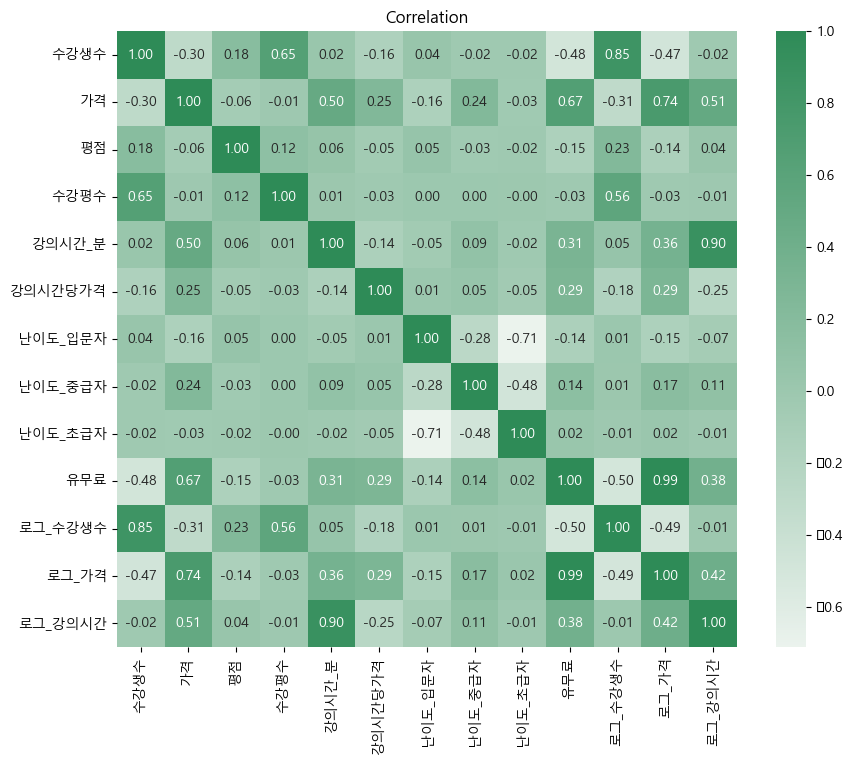

In [5]:
cmap = sns.light_palette('seagreen', as_cmap=True)

plt.figure(figsize=(10, 8))
sns.heatmap(df1.corr(), annot=True, cmap=cmap, fmt=".2f", annot_kws={"size": 10})
plt.title("Correlation")
plt.show()

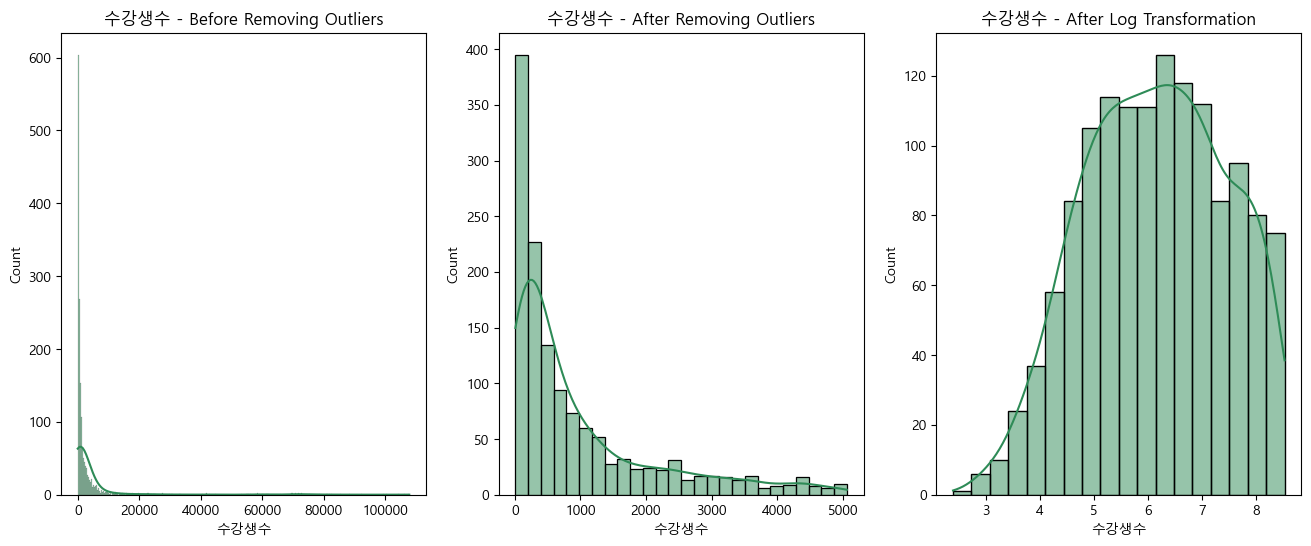

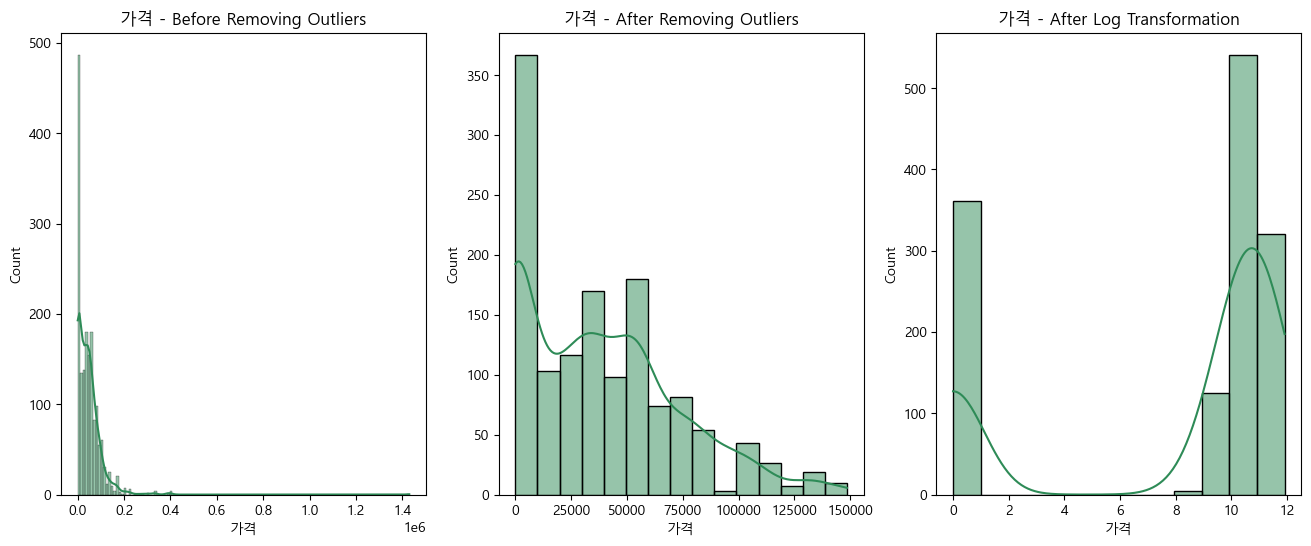

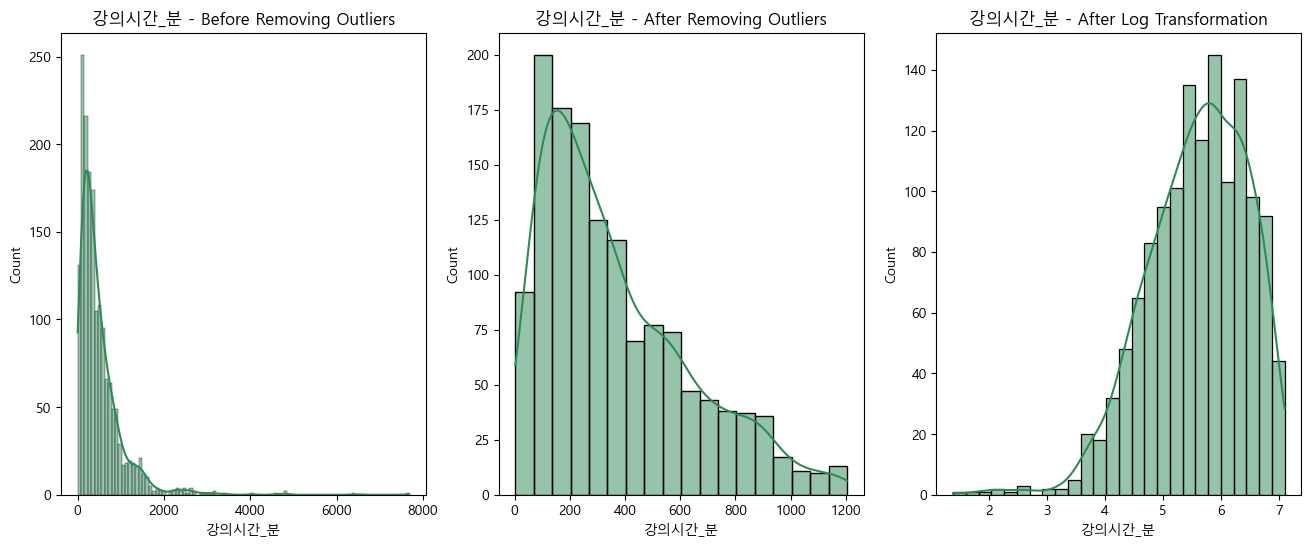

In [6]:
for column in columns_to_remove_outliers:
    plt.figure(figsize=(16, 6))
    
    #before
    plt.subplot(1, 3, 1)
    sns.histplot(df[column], kde=True, color = 'seagreen')
    plt.title(f'{column} - Before Removing Outliers' )
    
    #after
    plt.subplot(1, 3, 2)
    sns.histplot(df1[column], kde=True, color = 'seagreen')
    plt.title(f'{column} - After Removing Outliers')
    
    #log_trans
    plt.subplot(1, 3, 3)
    sns.histplot(np.log1p(df1[column]), kde=True, color = 'seagreen')
    plt.title(f'{column} - After Log Transformation')
    
    plt.show()

In [7]:
print(shapiro(df1['로그_수강생수']))
print(anderson(df1['로그_수강생수']))
print(levene(df1['로그_수강생수'], df1['로그_가격']))

ShapiroResult(statistic=0.9822836518287659, pvalue=8.121748933109796e-12)
AndersonResult(statistic=4.930499091092997, critical_values=array([0.574, 0.654, 0.785, 0.915, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
LeveneResult(statistic=308.562503459462, pvalue=1.7207205812348635e-65)


In [8]:
df1.head()

,강좌명,수강생수,가격,평점,수강평수,강의게시일,강의시간_분,강의시간당가격,난이도_입문자,난이도_중급자,난이도_초급자,유무료,로그_수강생수,로그_가격,로그_강의시간
0,[2024 NEW] 개발자를 위한 쉬운 도커,170,61600,5.0,3,2024-01-08,594,6222,0,0,1,1,5.141664,11.028433,6.388561
1,Next + React Query로 SNS 서비스 만들기,1330,69300,4.6,14,2023-12-04,886,4693,0,1,0,1,7.193686,11.146215,6.787845
2,피그마 배리어블을 활용한 디자인 시스템 구축하기,338,79200,5.0,14,2023-11-09,809,5873,0,0,1,1,5.826000,11.279744,6.697034
3,이득우의 언리얼 프로그래밍 Part1 - 언리얼 C++의 이해,1182,99000,5.0,153,2023-04-13,595,9983,0,1,0,1,7.075809,11.502885,6.390241
4,제대로 파는 Git & GitHub - by 얄코,4963,44000,4.9,228,2022-01-21,334,7904,1,0,0,1,8.509967,10.691968,5.814131


In [9]:
model = ols("로그_수강생수 ~ 로그_가격 + 평점 + 로그_강의시간 + 난이도_입문자 + 난이도_중급자 + 난이도_초급자 + 유무료", data=df1).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                로그_수강생수   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     103.8
Date:                Thu, 18 Jan 2024   Prob (F-statistic):          1.86e-107
Time:                        15:50:00   Log-Likelihood:                -2014.1
No. Observations:                1351   AIC:                             4042.
Df Residuals:                    1344   BIC:                             4079.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4059      0.315      7.633      0.0

In [10]:
# 오차항 검정
residuals = model.resid
residuals
print(shapiro(residuals))
print(anderson(residuals))
print(levene(residuals, df1['로그_수강생수']))

ShapiroResult(statistic=0.9986176490783691, pvalue=0.3656460642814636)
AndersonResult(statistic=0.30291415941201194, critical_values=array([0.574, 0.654, 0.785, 0.915, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
LeveneResult(statistic=72.8808740886526, pvalue=2.2623442828431904e-17)


In [11]:
# 표준화된 회귀계수 확인
standardized_coefficients = model.params / model.bse  # 각 계수를 표준오차로 나눠줌
print("Standardized Coefficients:")
print(standardized_coefficients)

Standardized Coefficients:
Intercept    7.633115
로그_가격       -2.112460
평점           6.449461
로그_강의시간      8.126756
난이도_입문자      5.414108
난이도_중급자      8.440738
난이도_초급자      6.907430
유무료         -0.553100
dtype: float64


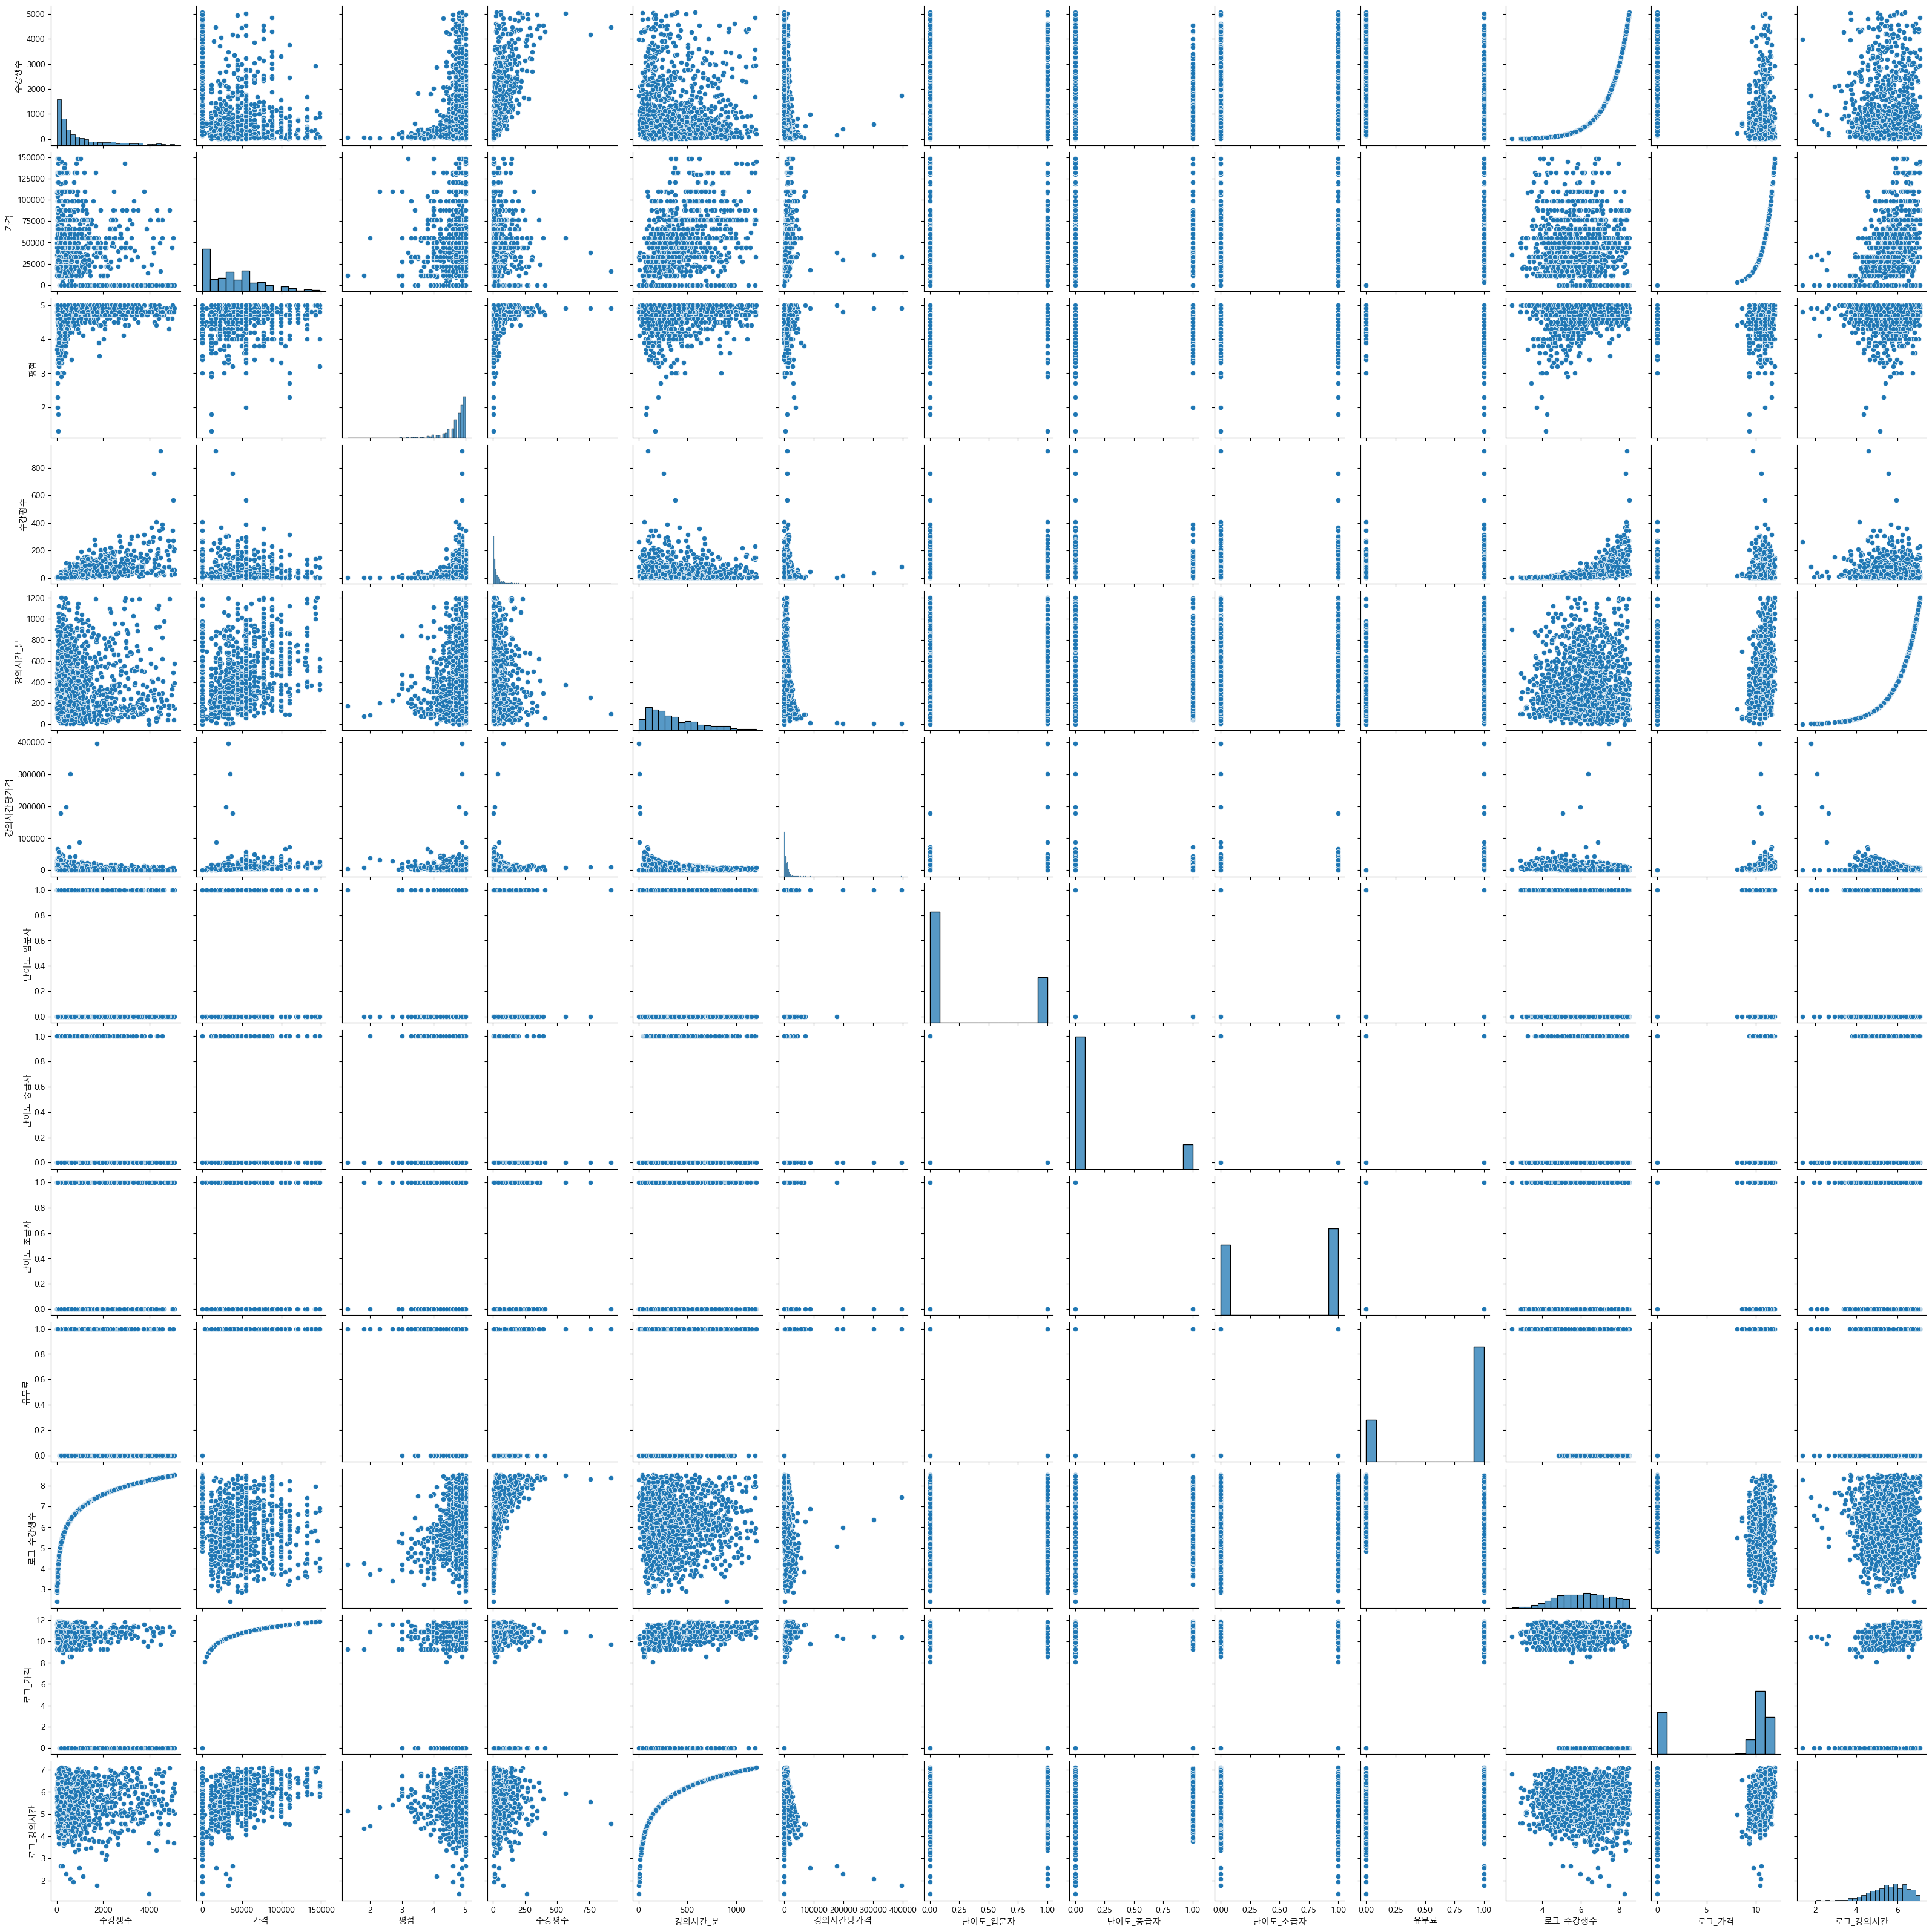

In [12]:
sns.pairplot(df1)

In [13]:
df1.head(1)

,강좌명,수강생수,가격,평점,수강평수,강의게시일,강의시간_분,강의시간당가격,난이도_입문자,난이도_중급자,난이도_초급자,유무료,로그_수강생수,로그_가격,로그_강의시간
0,[2024 NEW] 개발자를 위한 쉬운 도커,170,61600,5.0,3,2024-01-08,594,6222,0,0,1,1,5.141664,11.028433,6.388561


In [14]:
# 의사결정나무
X = df1.drop(['강좌명', '수강생수', '가격','수강평수', '강의게시일', '강의시간당가격','강의시간_분', '로그_수강생수'], axis=1)
y = df1['로그_수강생수']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tree_model = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_model.fit(X_train, y_train)

y_pred = tree_model.predict(X_test)

print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
# 학습된 의사결정나무 구조
tree_rules = export_text(tree_model, feature_names=list(X.columns))

Mean Squared Error: 1.1018105541476864


In [15]:
y1=pd.DataFrame()
y1['pred']=y_pred
y1

,pred
0,7.164056
1,6.092907
2,6.092907
3,6.092907
4,6.092907
...,...
266,6.092907
267,6.092907
268,5.242186
269,6.092907


In [16]:
# 훈련 데이터 예측
y_train_pred = tree_model.predict(X_train)

# 훈련 데이터 평가 지표 출력
train_mse = mean_squared_error(y_train, y_train_pred)
print("Training Mean Squared Error:", train_mse)

# 테스트 데이터 평가 지표 출력
test_mse = mean_squared_error(y_test, y_pred)
print("Test Mean Squared Error:", test_mse)

Training Mean Squared Error: 1.0451317852748327
Test Mean Squared Error: 1.1018105541476864


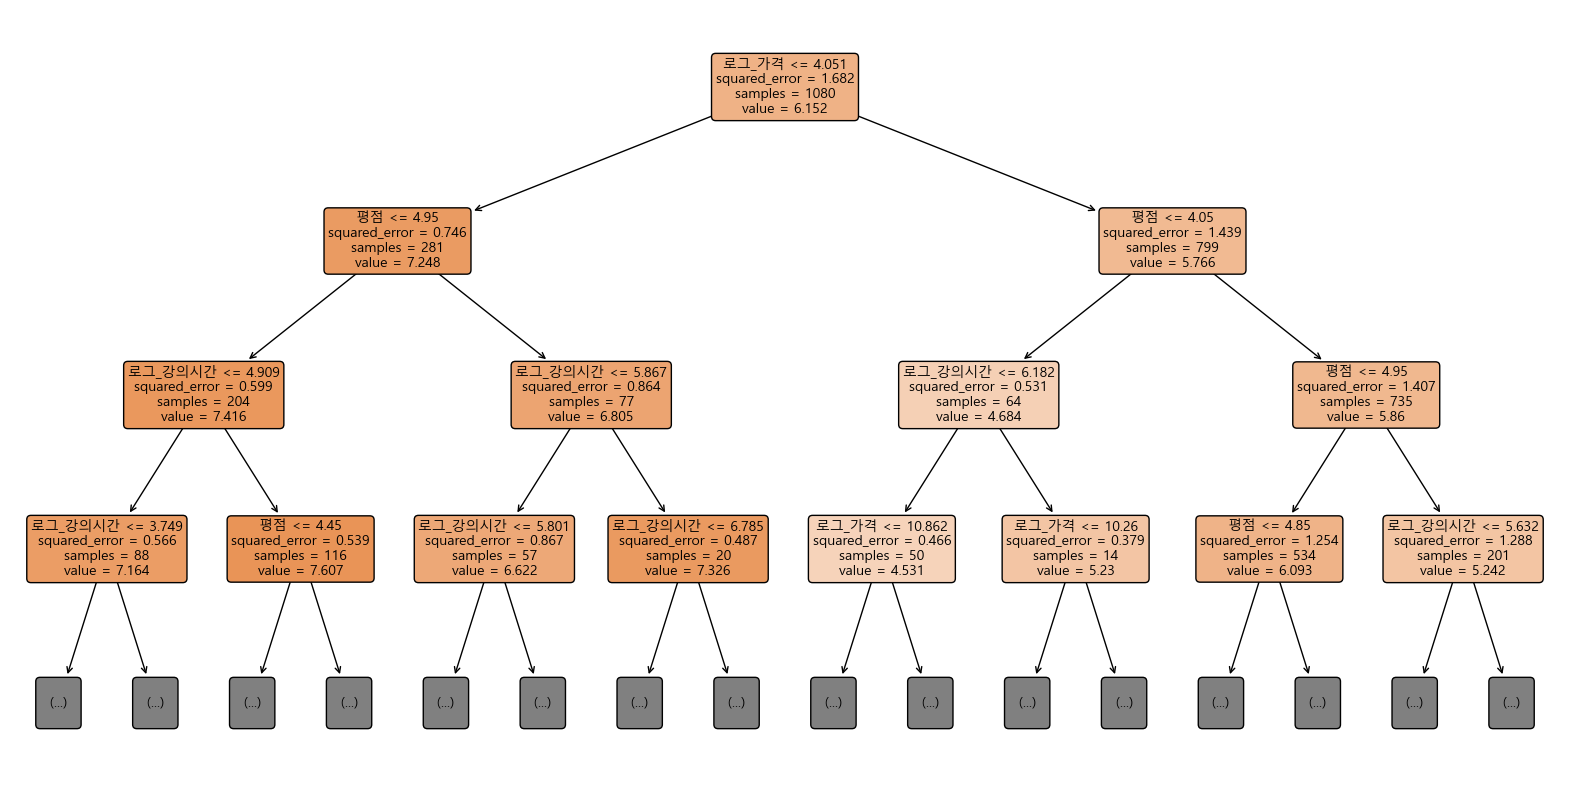

In [17]:
from sklearn.tree import plot_tree
# 의사결정나무 모델 생성 및 학습
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)
# 트리 시각화
plt.figure(figsize=(20, 10))
plot_tree(tree_model, feature_names=list(X.columns), filled=True, rounded=True, fontsize=10, max_depth=3)
plt.savefig("decision_tree.png")  # 이미지 저장
#plt.show() 

In [ ]:
importances = tree_model.feature_importances_
feature_names = X.columns

# 중요도를 기준으로 내림차순 정렬
indices = importances.argsort()[::-1]

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[indices], align="center", color = "seagreen")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance of Decision Tree")
plt.show()